<a href="https://colab.research.google.com/github/JOTOR/Examples_Python/blob/master/Sklearn_genetic_op_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sklearn-genetic-opt Demo**

By: jhonnatan.torres.suarez@gmail.com

Created on: Feb 2022

___

This notebook is a simple demo about how to use **Sklearn-genetic-opt**, a python library for hyperparameter tuning based on *evolutionary algorithms*, according to the [**Official Documentation**](https://sklearn-genetic-opt.readthedocs.io/en/stable/index.html):

>This is meant to be an alternative to popular methods inside scikit-learn such as Grid Search and Randomized Grid Search for hyperparameters tuning, and from RFE, Select From Model for feature selection.

>Sklearn-genetic-opt uses evolutionary algorithms from the deap package to choose a set of hyperparameters that optimizes (max or min) the cross-validation scores, it can be used for both regression and classification problems.

As the library name suggests, it does support scikit-learn estimators but What about **Xgboost**?
___

Installing the main library and importing the another required libraries

In [ ]:
!pip install sklearn-genetic-opt -q

In [ ]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier

## Data
Since this is a simple demo, I am using the famous (*and probably overused*) **Titanic** dataset

In [ ]:
np.random.seed(1234)
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

In [ ]:
numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["embarked", "sex", "pclass"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [ ]:
SCALE_POS = y.value_counts()[0]/y.value_counts()[1]

Attaching the XGBClassifier into the pipeline

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", XGBClassifier(subsample=0.5, scale_pos_weight=SCALE_POS, max_depth=3, random_state=1234))]
)

In [ ]:
#clf.get_params()

## *Evolved Estimator*

Importing the evolutionary algorithms and defining the *search space*

In [ ]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous

You can use a **Continuous** *search space* with a *uniform* or *log-uniform* arguments, more info is available at https://sklearn-genetic-opt.readthedocs.io/en/stable/api/space.html

In [ ]:
param_grid = {'classifier__reg_alpha': Continuous(0, 1),
              'classifier__reg_lambda': Continuous(0.1, 1),
              'classifier__n_estimators': Integer(3, 7),
              'classifier__learning_rate': Continuous(0.1, 0.9)}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
evolved_estimator = GASearchCV(estimator=clf,
                              cv=cv,
                              generations=10, 
                              scoring='accuracy',
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234)

Fitting the **evolved estimator**, the process is similar than the randomized search available in scikit-learn, you can define the number of "iterations" with the **generations** parameter, in this case, I am working with 10 iterations

In [ ]:
evolved_estimator.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.776571	0.00806688 	0.798016   	0.748901   
1  	100   	0.783037	0.00488093 	0.792605   	0.769672   
2  	100   	0.785332	0.00510705 	0.794838   	0.775125   
3  	100   	0.787605	0.00486925 	0.800232   	0.775065   
4  	100   	0.787687	0.00423861 	0.794838   	0.774014   
5  	100   	0.788059	0.00434059 	0.79807    	0.774044   
6  	100   	0.788835	0.00373696 	0.794838   	0.778326   
7  	100   	0.789012	0.004371   	0.796911   	0.778326   
8  	100   	0.790127	0.00451192 	0.798064   	0.778386   
9  	100   	0.790536	0.00421046 	0.800208   	0.781635   
10 	100   	0.79075 	0.00635205 	0.803427   	0.775042   


GASearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
           estimator=Pipeline(steps=[('preprocessor',
                                      ColumnTransformer(transformers=[('num',
                                                                       Pipeline(steps=[('imputer',
                                                                                        SimpleImputer(strategy='median')),
                                                                                       ('scaler',
                                                                                        StandardScaler())]),
                                                                       ['age',
                                                                        'fare']),
                                                                      ('cat',
                                                                       OneHotEncoder(handle_unknown='ignore'),
             

##Using the best estimator

Getting the best parameters

In [ ]:
print(evolved_estimator.best_params_)

{'classifier__reg_alpha': 0.49762234455838394, 'classifier__reg_lambda': 0.20242643909505617, 'classifier__n_estimators': 7, 'classifier__learning_rate': 0.36252028889729304}


In [ ]:
preds = evolved_estimator.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       247
           1       0.70      0.75      0.72       146

    accuracy                           0.79       393
   macro avg       0.77      0.78      0.77       393
weighted avg       0.79      0.79      0.79       393



## "Plotting the evolution"

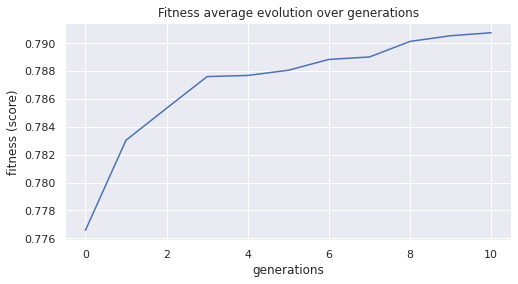

In [ ]:
import matplotlib.pyplot as plt
from sklearn_genetic.plots import plot_fitness_evolution
plt.figure(figsize=(8,4))
plot_fitness_evolution(evolved_estimator)
plt.show()

## Closing Comments


*   This library does support the scikit-learn wrapper of XGBoost; *I am pending to test if this library does support the [CatBoostClassifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)* 
*   It can be a great alternative to the *GridSearchCV* and *RandomizedSearchCV* available in scikit-learn

## References


*   This exampled was adapted from : https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/basic_usage.html# 
*   Official Documentation: https://sklearn-genetic-opt.readthedocs.io/en/stable/index.html

